In [ ]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import stLVG_upload
from stLVG_upload.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from stLVG_upload.viz import match_3D_multi, hist, Sankey, build_3D
from stLVG_upload.metrics import region_statistics

In [52]:
adata_1=sc.read_h5ad(r"D:\ppppaper\data\Result\ATAC_stereo_adata1.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 4132 × 18339
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - Aire', 'batch_name_idx', 'barcode', 'suffix', 'x1', 'x2', 'p1', 'p2', 'Barcodes', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'Barcodes_cut', 'slice_name', 'batch_name', 'mclust', 'target_celltype'
    uns: 'Spatial_Net', 'annotation_colors', 'batch_name_colors', 'mclust_colors', 'neighbors', 'target_celltype_colors', 'umap'
    obsm: 'SLAT', 'X_glue', 'X_seurat', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [53]:
adata_2=sc.read_h5ad(r"D:\ppppaper\data\Result\ATAC_stereo_adata2.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 2099 × 18339
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - Aire', 'batch_name_idx', 'barcode', 'suffix', 'x1', 'x2', 'p1', 'p2', 'Barcodes', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'Barcodes_cut', 'slice_name', 'batch_name', 'mclust', 'target_celltype'
    uns: 'annotation_colors', 'batch_name_colors', 'mclust_colors', 'neighbors', 'target_celltype_colors', 'umap'
    obsm: 'X_glue', 'X_seurat', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [54]:
csv_data = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\crossomics_PCA_com.csv", index_col=0)
print(csv_data.head())
csv_data.shape

                  PC1       PC2       PC3       PC4       PC5       PC6  \
301_191_RNA -1.912555 -3.898775 -3.724475 -0.742021  4.038951  0.537911   
301_192_RNA -2.341872 -3.743357 -4.090086 -0.910126  3.764534  0.456477   
301_193_RNA -2.181036 -3.303525 -3.724451 -0.562416  3.364477  0.428406   
301_194_RNA -2.803372 -4.043713 -4.932660 -1.208954  3.767793  0.835390   
301_195_RNA -2.820967 -3.624381 -5.178380 -1.236721  3.937230  1.006504   

                  PC7       PC8       PC9      PC10      PC11      PC12  \
301_191_RNA  0.851685  0.026508 -0.504888 -2.664062 -0.852473 -0.728647   
301_192_RNA  0.889979  0.106190 -1.064453 -2.124848 -0.994982 -1.394393   
301_193_RNA  0.856829  1.064315 -1.528869 -2.032002 -1.186846 -1.458697   
301_194_RNA  0.899601  0.772187 -1.771022 -0.960968 -0.228272 -1.645790   
301_195_RNA  1.169315  1.662188 -1.976164 -0.712877 -0.993569 -1.676538   

                 PC13      PC14      PC15      PC16      PC17      PC18  \
301_191_RNA  0.776426 -

(6231, 20)

In [55]:
data_seq = csv_data.iloc[:4132]  
data_atac = csv_data.iloc[4132:]

In [56]:
data_seq

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
301_191_RNA,-1.912555,-3.898775,-3.724475,-0.742021,4.038951,0.537911,0.851685,0.026508,-0.504888,-2.664062,-0.852473,-0.728647,0.776426,-0.022948,0.514544,0.309023,0.460310,-0.490295,-0.200960,0.370058
301_192_RNA,-2.341872,-3.743357,-4.090086,-0.910126,3.764534,0.456477,0.889979,0.106190,-1.064453,-2.124848,-0.994982,-1.394393,0.826852,-0.338338,1.508552,0.270085,0.306373,-0.025574,-0.415442,-0.185234
301_193_RNA,-2.181036,-3.303525,-3.724451,-0.562416,3.364477,0.428406,0.856829,1.064315,-1.528869,-2.032002,-1.186846,-1.458697,0.844253,-0.638622,1.930053,0.041527,-0.051537,0.462386,-0.404158,-0.345608
301_194_RNA,-2.803372,-4.043713,-4.932660,-1.208954,3.767793,0.835390,0.899601,0.772187,-1.771022,-0.960968,-0.228272,-1.645790,0.236513,-0.494436,1.990444,1.068658,0.291998,0.308751,-0.876980,-0.408021
301_195_RNA,-2.820967,-3.624381,-5.178380,-1.236721,3.937230,1.006504,1.169315,1.662188,-1.976164,-0.712877,-0.993569,-1.676538,-0.314339,-0.223015,2.295839,-0.015268,0.478142,0.434904,-0.299446,-0.760208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388_193_RNA,1.508603,2.844456,-0.453898,1.122879,-2.374609,-0.965511,1.736670,0.478573,-2.519526,-2.106248,1.901153,-0.122698,-0.737690,-1.133764,2.440075,-6.191120,4.707753,3.300960,0.245035,-2.382388
389_191_RNA,1.186584,2.761929,-0.643621,1.034121,-2.096038,-1.404405,1.268318,0.485872,-1.902103,-1.699584,1.836401,-0.162678,-0.882933,-0.674468,2.332331,-5.512202,4.066403,2.986731,0.384314,-1.801372
389_192_RNA,1.207314,2.369876,-0.707485,1.018968,-1.702494,-1.158546,1.784140,0.340400,-2.286656,-2.252667,1.808948,-0.200565,-0.827551,-0.886062,2.770693,-5.879946,4.069288,2.986212,0.174312,-2.409287
389_259_RNA,-0.114666,0.575205,-0.181374,1.150478,-4.953603,2.299307,5.319987,-1.673570,-0.108326,-0.122373,-0.125425,1.022243,1.245281,-0.553009,0.901997,-0.004776,-0.112329,0.014588,0.115991,0.410142


In [57]:
data_atac

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0_ATAC,-5.328001,4.132137,0.778787,0.032460,1.435528,0.151560,-0.380733,-1.088194,-1.160993,0.669812,0.021840,-0.861234,0.140044,-1.007085,1.538891,-0.470382,-0.903684,0.807317,0.328747,0.339786
1_ATAC,12.141497,-3.803424,0.280660,-1.318314,-0.929094,2.078612,-1.076506,0.699747,-1.007481,-0.469312,0.525051,-0.212833,-0.281150,-0.912258,1.273050,-0.512045,2.273641,-0.747664,-0.103166,2.208767
2_ATAC,-2.621808,3.687254,1.210654,0.404480,0.771280,-2.532263,0.184847,0.144153,0.224485,-0.172825,-0.054875,0.066130,0.544252,-0.445886,-0.032923,-0.108444,1.043708,0.020184,-1.221698,0.504526
3_ATAC,-3.202767,1.523343,-0.050575,1.884347,-0.362690,-1.376009,0.689793,0.652608,0.670028,-1.738538,-0.108249,1.112619,-0.710420,1.392346,0.041609,2.200072,0.147355,-1.200495,0.589095,0.546792
4_ATAC,10.527934,-3.055098,-0.376771,-0.685806,-0.378592,0.894110,-0.072126,-0.059190,0.639462,1.487602,-0.280228,0.353211,-2.683256,0.968886,-0.037132,-0.754858,0.014304,1.107706,-0.717151,-0.873901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2094_ATAC,-1.398383,4.376265,0.993551,-1.896292,-0.091561,-2.580777,-0.317342,-1.611426,0.525469,-1.081118,-2.418225,0.077858,3.060042,-0.395755,-0.051631,1.122320,0.142459,-0.597519,-0.044021,0.979333
2095_ATAC,-2.877867,4.173380,-0.120294,-0.477414,-0.142383,-1.633122,-1.376264,-0.319897,-1.692687,-0.333679,-0.452072,0.056911,-1.135064,1.856987,1.522847,0.500716,-1.590504,-1.569775,-0.399175,-0.275862
2096_ATAC,-6.152321,-3.344800,-0.274325,-3.502256,-0.543516,2.436451,-0.396124,0.583527,1.190798,-0.012548,-0.827390,-1.717326,0.192280,1.736452,-1.036043,1.847732,-1.030354,0.627681,-1.835273,0.699760
2097_ATAC,5.010568,-0.128727,0.094385,0.111237,-1.104731,0.275309,-0.212047,-1.153679,-2.009078,-1.012469,0.382276,-1.982002,-1.322132,-1.626806,0.146637,-0.554929,0.407102,-0.560162,-0.444086,-0.135557


In [58]:
pca_array_seq = data_seq.values  # 转换为NumPy数组
adata_1.obsm["X_pca"] = pca_array_seq

In [59]:
pca_array_atac = data_atac.values  # 转换为NumPy数组
adata_2.obsm["X_pca"] = pca_array_atac

In [60]:
embd0 = adata_1.obsm['X_pca']
embd1 = adata_2.obsm['X_pca']
adata_2.obs['annotation'] = adata_2.obs['Clusters']
adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


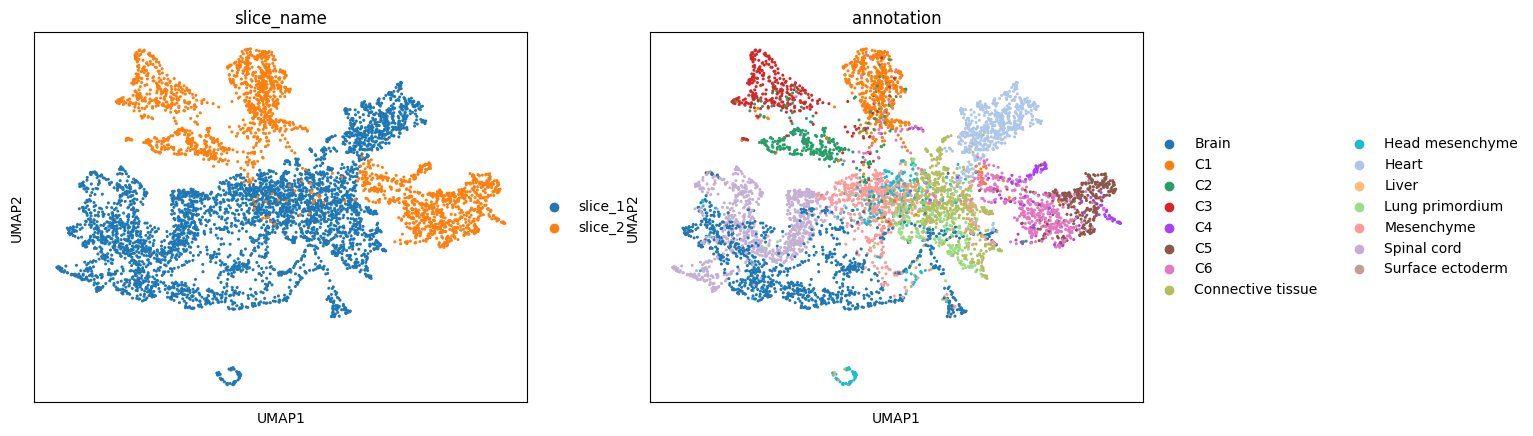

In [61]:
sc.pp.neighbors(adata_com, use_rep= 'X_pca')
sc.tl.umap(adata_com)
sc.pl.umap(adata_com, color= ['slice_name', 'annotation'])

In [62]:
best, index, distance = spatial_match([embd0, embd1], adatas=[adata_1, adata_2])
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [63]:
first_indices = matching[0]
second_indices = matching[1]
second_array_labels = adata1_df.iloc[second_indices]['celltype'].values

max_index = first_indices.max()
new_labels = np.empty(max_index + 1, dtype=object)

# transfer
new_labels[first_indices] = second_array_labels

adata_2.obs['transferred_labels'] = new_labels

In [64]:
spot_size_1 = 1
spot_size_2 = 10
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

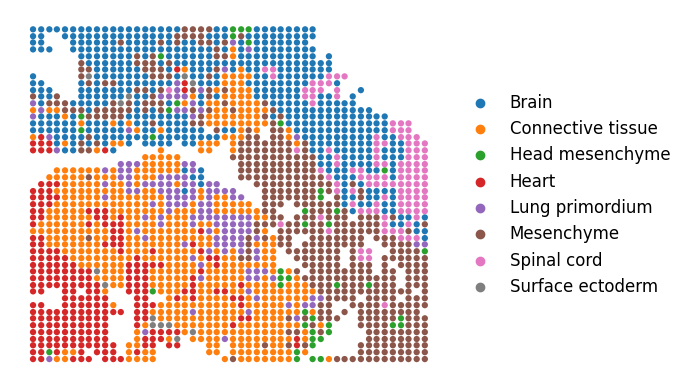

In [65]:
sc.pl.spatial(adata_2, img_key=None, color=['transferred_labels'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size_2)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

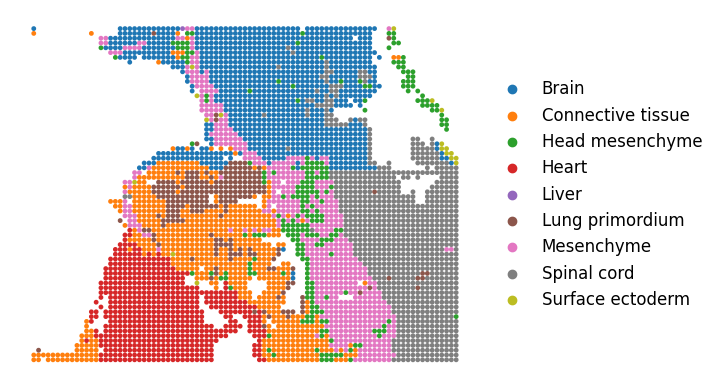

In [66]:
sc.pl.spatial(adata_1, img_key=None, color=['annotation'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size_1)

In [67]:
from scSLAT.viz import match_3D_multi, hist, match_3D_celltype, build_3D

In [68]:
atac_score = pd.read_csv(r"D:\WeChat\WeChat Files\wxid_blfvg4sns2ju22\FileStorage\File\2025-02\ArchR_impute_score.csv", index_col=0).T
atac_score['barcodes'] = atac_score.index.str.split('-').str[0].str.split('#').str[1]
atac = sc.read_h5ad(r"D:\ppppaper\data\ATAC_stereo\Mouse_embryo_ME11_20um_ATAC_seq.h5ad")
atac.obs['barcodes'] = atac.obs['Barcodes'].str.split('-').str[0].str.split('#').str[1]
merged_df = pd.merge(atac.obs, atac_score, on = 'barcodes', suffixes = ('_left', '_right'))
merged_df.index = merged_df.barcode
atac.obs = merged_df

In [69]:
adata2_df['Tnnt2'] = sc.get.obs_df(atac, 'Tnnt2').values
adata1_df['Tnnt2'] = sc.get.obs_df(adata_1, 'Tnnt2').values

In [70]:
import seaborn as sns
cmap = sns.light_palette("orange", n_colors=200, as_cmap=True)

dataset1: 9 cell types; dataset2: 6 cell types; 
                    Total :15 celltypes; Overlap: 0 cell types 
                    Not overlap :[['Liver', 'Spinal cord', 'Surface ectoderm', 'Head mesenchyme', 'Connective tissue', 'Heart', 'Lung primordium', 'Mesenchyme', 'Brain', 'C5', 'C1', 'C6', 'C4', 'C2', 'C3']]
Subsampled 2098 pairs from 2099


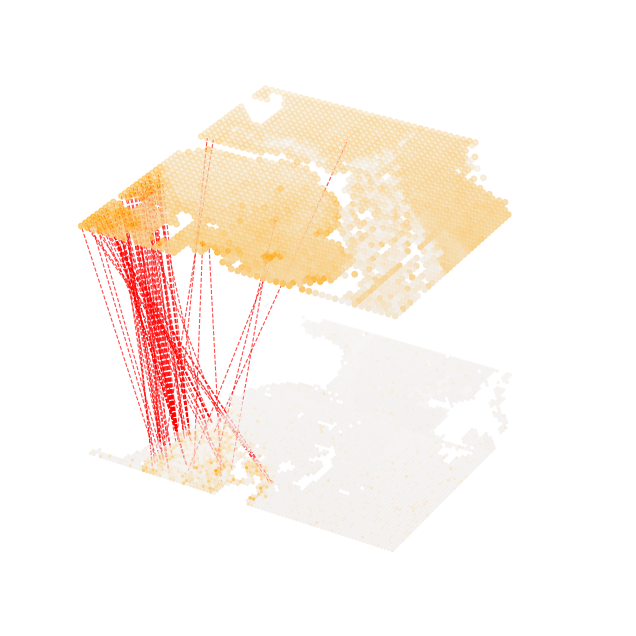

In [72]:
test = match_3D_celltype(adata1_df, adata2_df, matching, meta='celltype', highlight_celltype=[['Heart'],['C4']], expr='Tnnt2',rotate=['y','y'],
                         subsample_size = matching.shape[1]-1, scale_coordinate=True)
test.draw_3D(size=[8, 8], line_width=0.8, point_size=[3,15], hide_axis=True, cmap = cmap, show_error=False)